# Analysis of LM Perplexities

## Imports and data loading

In [1]:
%matplotlib widget
import numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns, pandas, orjson
from tqdm import tqdm

In [2]:
def get_xy(np_array):
  return np.where(~np.isnan(np_array))[0], np_array[~np.isnan(np_array)]

In [3]:
def get_dict_of_arrays(exp_model_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='pppl.npy',convert_for_plot=True):
    np_arrays = {}
    
    for exp, models in exp_model_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            if convert_for_plot:
                np_arrays[model] = get_xy(np.load(file_name))
            else:
                np_arrays[model] = np.load(file_name)

    return np_arrays

In [4]:
def get_dict_of_df(df_dict, read_directory='../log_calculations/unified_outputs/', fname_to_read='filtered_df.csv'):
    
    dfs = {}
    
    for exp, models in df_dict.items():
        for model in models:
            file_name = os.path.join(read_directory, exp, model, fname_to_read)
            dfs[model] = pandas.read_csv(file_name)
    return dfs

#### Define the models we're interested in working with using a dictionary of experiment_name:model_name pairs, and load the data

In [5]:
models = {
       'every_5_5000' : ['allenai/scibert_scivocab_cased', 'bert-base-cased', 'roberta-base', 'xlm-roberta-base']
}

In [6]:
dfs = get_dict_of_df(models, fname_to_read='filtered_df_with_moses_tokens.tsv')
pppl_arrays = get_dict_of_arrays(models) # PPPL already calculated with subwords
np_arrays = get_dict_of_arrays(models, fname_to_read='filtered_log_probs.npy', convert_for_plot=False) #Load the raw data to re-do calculations

print(f'{np_arrays[next(iter(dfs))].shape}\t(bin x sample_size x max_seq_len)')

(100, 5000, 128)	(bin x sample_size x max_seq_len)


In [7]:
# Cleanup some of the columns from the df
for model, df in dfs.items():
    dfs[model] = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    print(f'Model: {model:40s}\tNum Rows: {len(df):10d}')

Model: allenai/scibert_scivocab_cased          	Num Rows:      97413
Model: bert-base-cased                         	Num Rows:      98168
Model: roberta-base                            	Num Rows:      97587
Model: xlm-roberta-base                        	Num Rows:      98157


Theres a difference in the number of rows because we filter out based on subwords and padding tokens, which is different for each abstract depending on the model

## Plotting Perplexities

### Perplexity normalized by subword

Text(63.347222222222214, 0.5, 'PPPL (Subword)')

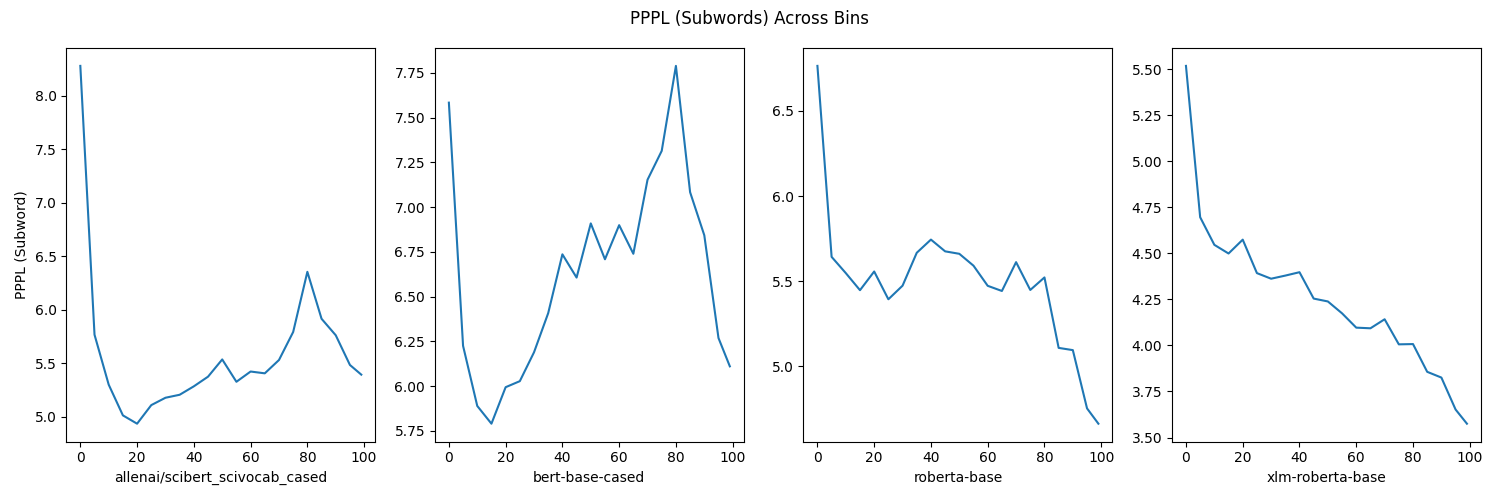

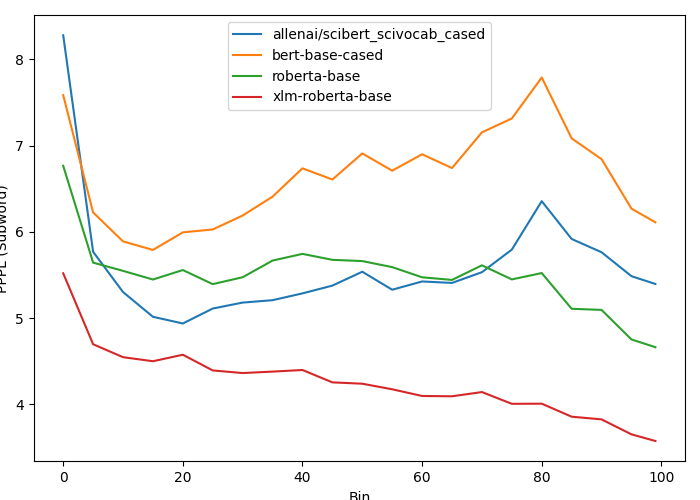

In [28]:

num_models = len(dfs)

ip_f, ip_a = plt.subplots(1, num_models, figsize=(15,5))
ipa_f, ipa_a = plt.subplots(figsize=(7,5))

for i, (model, array) in enumerate(pppl_arrays.items()):
    ip_a[i].plot(array[0], array[1])
    ip_a[i].set_xlabel(model)
    ipa_a.plot(array[0], array[1], label=model)
    
ip_a[0].set_ylabel('PPPL (Subword)')
ip_f.suptitle('PPPL (Subwords) Across Bins')
ip_f.tight_layout()

ipa_f.tight_layout()
ipa_a.legend()
ipa_a.set_xlabel('Bin')
ipa_a.set_ylabel('PPPL (Subword)')

### Plot the PPPL using different normalization methods (Moses)

In [29]:
def calculate_pppl(arr, counts):
    """
        arr: numpy array of shape sample_size x max_seq len
        counts: numpy array of shape (sample_size,)
        
        returns: pppl normalized by counts across all samples
    """
    
    total_sum = np.nansum(arr) * -1
    total_counts = np.nansum(counts)
    return np.exp(total_sum / total_counts)

In [30]:
for i, (model, df) in enumerate(dfs.items()):
    dfs[model]['num_chars'] = df['abstract_input'].apply(lambda x : len(x))
    dfs[model]['num_spaces'] = df['abstract_input'].apply(lambda x : x.count(' '))

/rc_scratch/abeb4417/abeb4417/tmp/ipykernel_1552/169660144.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  moses_f, moses_a = plt.subplots(3, num_models, figsize=(15,5))


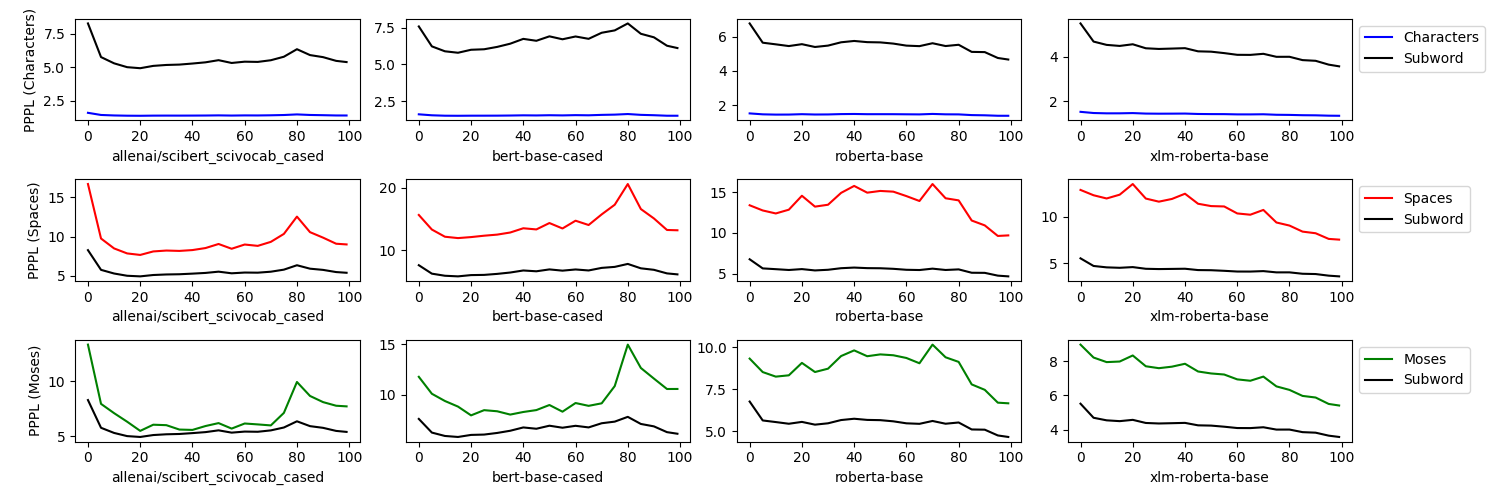

In [31]:
moses_f, moses_a = plt.subplots(3, num_models, figsize=(15,5))
colors = ['blue', 'red', 'green']

for k, (name, col) in enumerate(zip(['Characters', 'Spaces', 'Moses'],['num_chars', 'num_spaces', 'num_moses_tokens'])):
    for i, (model, df) in enumerate(dfs.items()):
        bins = df['bin'].unique()
        bins_pppl = np.zeros(bins.shape)

        for j, b in enumerate(bins):
            bin_counts = df[df['bin'] == b][col]
            np_indexer = df[df['bin'] == b]['local_id']
            arr = np_arrays[model]

            bins_pppl[j] = calculate_pppl(arr[b][np_indexer], bin_counts)

        moses_a[k][i].plot(bins, bins_pppl, color=colors[k], label=name)
        moses_a[k][i].plot(pppl_arrays[model][0], pppl_arrays[model][1], color='black', label='Subword')

        moses_a[k][i].set_xlabel(model)
    
    moses_a[k][0].set_ylabel(f'PPPL ({name})')

    moses_a[k][-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    
moses_f.tight_layout()

## Stratifying by Source Domain